### **Multi-Classification on clothe dataset**

## Exercise 1
Based on the tutorial above, it is requested to implement a CNN-based network to perform a multi-label classification solution. Download the image dataset "data.zip" on MyLearningSpace for this lab, the data is also available here:
https://drive.google.com/file/d/1uzR8oW7F4ONyptQQeN09MqIa4Oo2An4m/view?usp=sharing). 
This dataset contains 8 categories of images distributed as shown in the following structure (in total 22 directories):

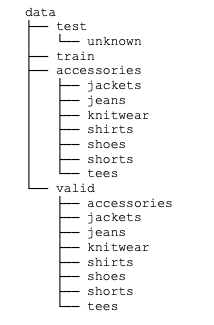

In [ ]:
# Monter votre Drive afin de pouvoir y'acceder 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# nous supposons que la base d'image se trouve dans le répertoire "IA-Vision" de votre Drive
from zipfile import ZipFile
file_name = "/content/drive/MyDrive/IA-Vision/data-clothes.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


# Package Import


In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras import models,optimizers,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import EarlyStopping

The file is alreday split into three dataset : Train, Validation and Test.

Images are divided in 8 classes : 

*   **Accessories**
*   **jackets**
*   **jeans**
*   **knitwear**
*   **shirts**
*   **shoes**
*   **shorts**
*   **tees** 

An example of the images in the dataset. All the images have a size of 432x300x3.

(432, 300, 3)


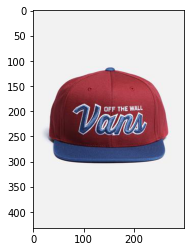

In [ ]:
# un exemple de lecture/affichage d'une image
img=plt.imread("/content/data/train/accessories/productimg_1.jpg")
plt.imshow(img)
print(img.shape)

In [ ]:
img2 = cv2.resize(cv2.imread("/content/data/train/accessories/productimg_1.jpg"),(150,150),interpolation=cv2.INTER_CUBIC)

#Reading and processing of the images.
We can resize all our images to a size of 266x150x3 (to speed up the training phase).
The labels are one-hot encoded, which means they are represented as an array of length n (the number of class) with the value 1 on the associated label index and 0 on the others. The images are shuffled.

Datasets sizes : 

*  Train : 3467 
*  Validation : 382 
*  Test : 8

*NB : the test dataset apppears to be really small. However, we only want to explore methods and not to find the best model for this problem.*  





In [ ]:
# Chargement de toutes les images:
path="data/"
train_dir = path+"train/"
test_dir = path+"validation/"
from sklearn.utils import shuffle

# Je redimensionne toutes nos images à une taille de 266x150x3 (surtout pour accélérer la phase d'apprentissage). 
# Les étiquettes sont encodées au format one-hot, ce qui signifie qu'elles sont représentées comme un de longueur n (le nombre de classe) avec la valeur 1 sur l'index d'étiquette associé et 0 sur les autres. 
# Les images sont mélangées (on utilise pour cela shuffle())

rows=266
columns=150

def read_process(dataset,columns,rows,rand=True):
    labels=["accessories","jackets","jeans","knitwear","shirts","shoes","shorts","tees"]
    dir=path+dataset+"/"
    X,Y=[],[]
    for j,label in enumerate(labels):
        for file in os.listdir(dir+label+"/"):
            X.append(cv2.resize(cv2.imread(dir+label+"/"+file),(columns,rows),interpolation=cv2.INTER_CUBIC))
            y=[0 for _ in range(len(labels))]
            y[j]=1
            Y.append(y)
    if rand : 
        return shuffle(np.array(X),np.array(Y))
    else:
        return np.array(X),np.array(Y)

def read_process_test(columns,rows):
    X_test=[]
    for file in os.listdir("/content/data/test/unknown/"):
        X_test.append(cv2.resize(cv2.imread("/content/data/test/unknown/"+file),(columns,rows),interpolation=cv2.INTER_CUBIC))
    return np.array(X_test)

X_train,Y_train=read_process("train",columns,rows)
X_val,Y_val=read_process("valid",columns,rows)
X_test=read_process_test(150,266)

Next, let's check the shape of our data. We can see that our train images are a rank 4 tensor, or we could say a 4 dimensional array with dimensions 3467 x 266 x 150 x 3 which respectively correspond to the size, height, width and channels of the lot.

In [ ]:
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)
print(X_test.shape)

(3467, 266, 150, 3) (3467, 8)
(382, 266, 150, 3) (382, 8)
(8, 266, 150, 3)


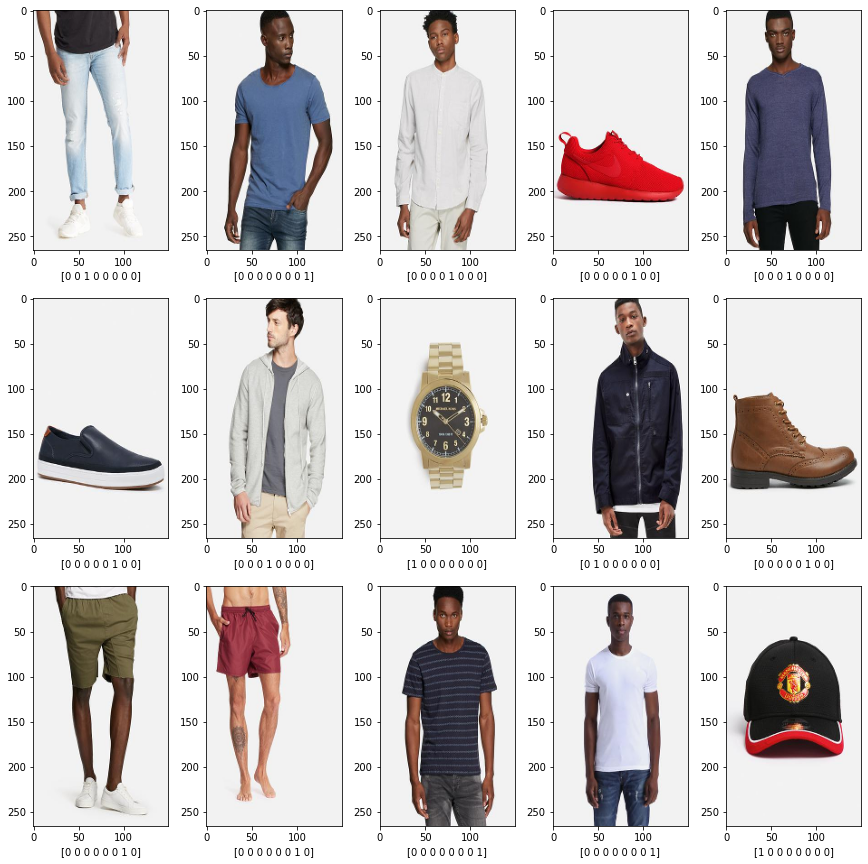

In [ ]:
fig, axs = plt.subplots(nrows=3, ncols=5, figsize=(15,15))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(cv2.cvtColor(X_train[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(str(Y_train[i]))
    plt.sca(ax)
plt.show()


# 1.1. Image calssification from-scratch
Design your model from scratch with an architecture similar to that presented in the tutorial a typical CNN, in which the first part consists of Convolutional and max-pooling layers which act as the feature extractor. The second part consists of the fully connected layer which performs non-linear transformations of the extracted features and acts as the classifier. 
For training the network, you follow the same workflow of create -> compile -> fit described above. Since it is a 8 class classification problem, you can use a categorical cross entropy loss and use RMSProp optimizer to train the network. Run it for some number of epochs (50 epochs)

In [ ]:
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img 

model = models.Sequential() # (1)
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(266, 150, 3)))#(2)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2))) 
# (3)
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten()) 
# (4)
model.add(layers.Dropout(0.5))  #Dropout for regularization 
# (5)
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(8, activation='sigmoid'))


In [ ]:
model.summary()
model.compile(loss='categorical_crossentropy', 
                optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 264, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 132, 74, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 130, 72, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 65, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 63, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 17, 128)      0

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

In [ ]:
#Create the image generators
ntrain = len(X_train)
nval = len(X_val) #We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32
train_generator = train_datagen.flow(X_train, Y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=batch_size)

In [ ]:
NAME = "CNN_FramScratch"
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
callback = EarlyStopping(monitor='loss', patience=3)

In [ ]:
history = model.fit(train_generator,
                                steps_per_epoch=ntrain // batch_size,
                                epochs=50,
                                validation_data=val_generator,
                                validation_steps=nval // batch_size,
                                callbacks=[tensorboard, callback])

Epoch 1/50
108/108 [==============================] - 17s 60ms/step - loss: 1.0063 - acc: 0.6466 - val_loss: 0.6968 - val_acc: 0.7585
Epoch 2/50
108/108 [==============================] - 6s 54ms/step - loss: 0.5845 - acc: 0.7776 - val_loss: 0.5184 - val_acc: 0.8182
Epoch 3/50
108/108 [==============================] - 6s 53ms/step - loss: 0.4406 - acc: 0.8399 - val_loss: 0.4141 - val_acc: 0.8352
Epoch 4/50
108/108 [==============================] - 6s 53ms/step - loss: 0.3602 - acc: 0.8734 - val_loss: 0.4451 - val_acc: 0.8239
Epoch 5/50
108/108 [==============================] - 6s 54ms/step - loss: 0.3133 - acc: 0.8821 - val_loss: 0.2796 - val_acc: 0.9062
Epoch 6/50
108/108 [==============================] - 6s 53ms/step - loss: 0.2679 - acc: 0.8999 - val_loss: 0.2479 - val_acc: 0.9148
Epoch 7/50
108/108 [==============================] - 6s 54ms/step - loss: 0.2394 - acc: 0.9103 - val_loss: 0.2718 - val_acc: 0.9062
Epoch 8/50
108/108 [==============================] - 6s 53ms/step -

In [ ]:
model.save_weights('model_weights.h5')
model.save('model_keras.h5')

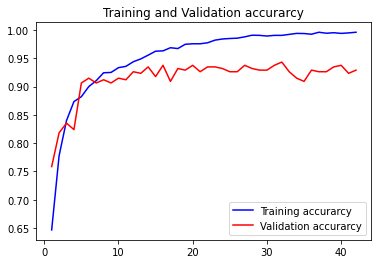

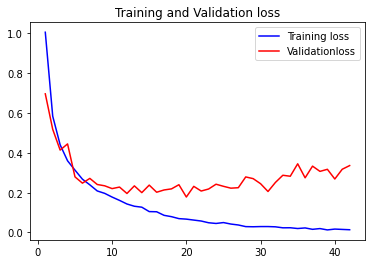

In [ ]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure() #Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validationloss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

#1.2. With Data Augmentation
One of the major reasons for overfitting is that you don’t have enough data to train your network. Apart from regularization, another very effective way to counter Overfitting is Data Augmentation. It is the process of artificially creating more images from the images you already have by changing the size, orientation etc of the image. It can be a tedious task but fortunately, this can be done in Keras using the ImageDataGenerator instance. Similare to above, train your model with Data Augmentation. Plot performance curves that show the evaluation of your model (TensorBoard with Keras is via a Keras callback). 

In [ ]:
model = models.Sequential() # (1)
model.add(layers.Conv2D(32, (3, 3), activation='relu',input_shape=(266, 150, 3)))#(2)
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2))) 
# (3)
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten()) 
# (4)
model.add(layers.Dropout(0.5))  #Dropout for regularization 
# (5)
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(8, activation='sigmoid'))

model.summary()
model.compile(loss='categorical_crossentropy', 
                optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 264, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 132, 74, 32)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 130, 72, 64)       18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 65, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 63, 34, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 31, 17, 128)     

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,   #Scale the image between 0 and 1
                                   rotation_range=40,
                                    width_shift_range=0.2,height_shift_range=0.2,shear_range=0.2,
                                    zoom_range=0.2,horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)  #We do not augment validation data. we only perform rescale

In [ ]:
#Create the image generators
ntrain = len(X_train)
nval = len(X_val) #We will use a batch size of 32. Note: batch size should be a factor of 2.***4,8,16,32,64...***
batch_size = 32
train_generator = train_datagen.flow(X_train, Y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=batch_size)

NAME = "CNN_FramScratch"
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
callback = EarlyStopping(monitor='loss', patience=8)

history = model.fit(train_generator,
                                steps_per_epoch=ntrain // batch_size,
                                epochs=50,
                                validation_data=val_generator,
                                validation_steps=nval // batch_size,
                                callbacks=[tensorboard, callback])

Epoch 1/50
108/108 [==============================] - 29s 262ms/step - loss: 1.5802 - acc: 0.4661 - val_loss: 1.0856 - val_acc: 0.6136
Epoch 2/50
108/108 [==============================] - 28s 262ms/step - loss: 1.2913 - acc: 0.5488 - val_loss: 0.9614 - val_acc: 0.6335
Epoch 3/50
108/108 [==============================] - 28s 262ms/step - loss: 1.1817 - acc: 0.5878 - val_loss: 0.8113 - val_acc: 0.6875
Epoch 4/50
108/108 [==============================] - 28s 258ms/step - loss: 1.0852 - acc: 0.6180 - val_loss: 0.7169 - val_acc: 0.7216
Epoch 5/50
108/108 [==============================] - 28s 257ms/step - loss: 1.0139 - acc: 0.6440 - val_loss: 0.6617 - val_acc: 0.7926
Epoch 6/50
108/108 [==============================] - 28s 263ms/step - loss: 0.9377 - acc: 0.6690 - val_loss: 0.5384 - val_acc: 0.8097
Epoch 7/50
108/108 [==============================] - 28s 259ms/step - loss: 0.9030 - acc: 0.6827 - val_loss: 0.5378 - val_acc: 0.8125
Epoch 8/50
108/108 [==============================] - 2

In [ ]:
model.save_weights('model_2_weights.h5')
model.save('model_2_keras.h5')

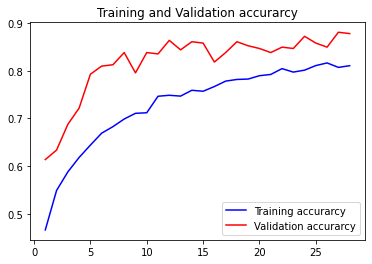

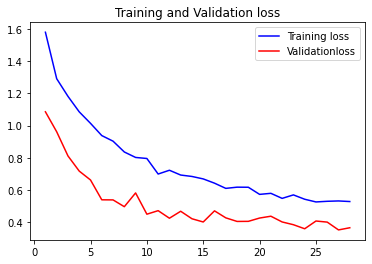

In [ ]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure() #Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validationloss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

#1.3. Image classification using different pre-trained models
ImageNet Large Scale Visual Recognition Challenge ([ILSVRC](https://image-net.org/challenges/LSVRC/2017/index)) is an annual competition organized by the ImageNet team since 2010, where research teams evaluate their computer vision algorithms various visual recognition tasks such as Object Classification and Object Localization. The training data is a subset of ImageNet with 1.2 million images belonging to 1000 classes. 

The winners of ILSVRC have been very generous in releasing their models to the open-source community. There are many models such as AlexNet, VGGNet, Inception, ResNet, Xception and many more which we can choose from, for our own task. Apart from the ILSVRC winners, many research groups also share their models which they have trained for similar tasks, e.g, MobileNet, SqueezeNet etc.
These networks are trained for classifying images into one of 1000 categories or classes.
In order to perform tests with these models, We can load the models in Keras using the following code: 

In [ ]:
# In this part, we use major pretrained model with ImageNet to observes their predictions. 
# The examples below are dedicated to VGG16 but are appliable to other CNN architectures. 
# Their input shape is 224x224 so it is necessary to resize all the images.

import numpy as np
from tensorflow.keras.applications import vgg16, inception_v3, resnet50, mobilenet

X_train,Y_train=read_process("train",224,224)
X_val,Y_val=read_process("valid",224,224)

vgg_model = vgg16.VGG16(weights='imagenet')

inception_model = inception_v3.InceptionV3(weights='imagenet')

resnet_model = resnet50.ResNet50(weights='imagenet')

mobilenet_model = mobilenet.MobileNet(weights='imagenet')

35363/35363 [==============================] - 0s 0us/step


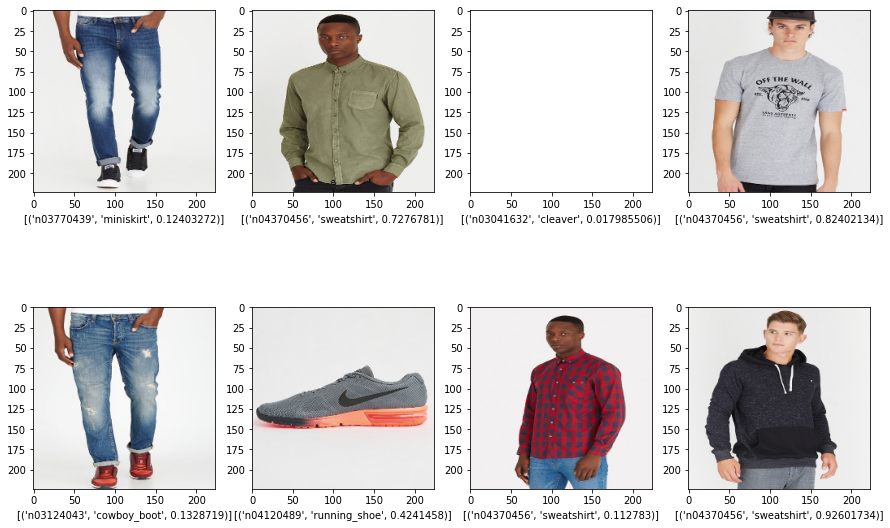

In [ ]:
X_test=read_process_test(224,224)

processed_image = vgg16.preprocess_input(X_test)
predictions = vgg_model.predict(processed_image)


Y_test=vgg16.decode_predictions(predictions,top=1)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(Y_test[i])
    plt.sca(ax)
plt.show()

1/1 [==============================] - 2s 2s/step


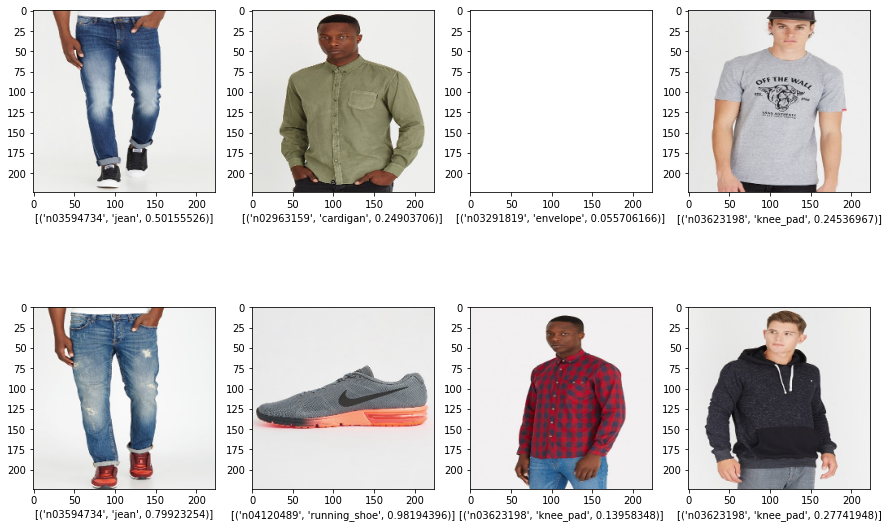

In [ ]:
processed_image = resnet50.preprocess_input(X_test)
predictions = resnet_model.predict(processed_image)


Y_test=resnet50.decode_predictions(predictions,top=1)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(Y_test[i])
    plt.sca(ax)
plt.show()

1/1 [==============================] - 0s 19ms/step


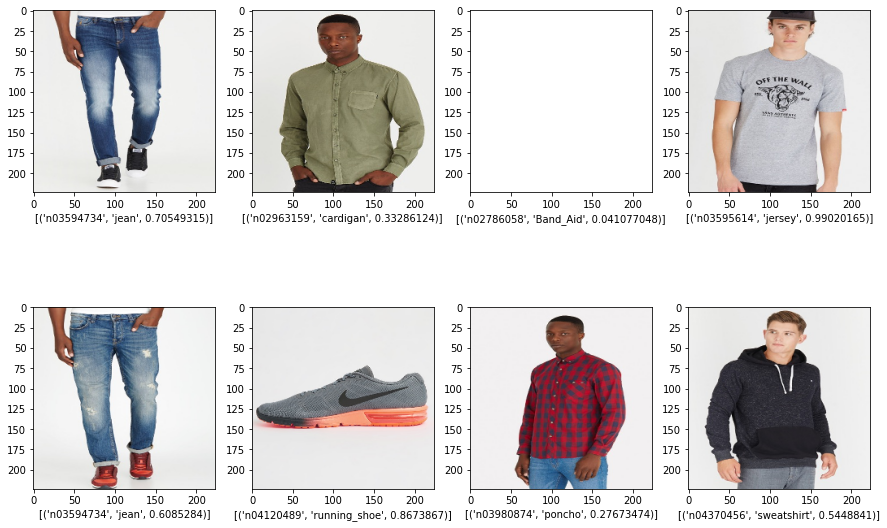

In [ ]:
!from tensorflow.keras.applications import mobilenet

processed_image = mobilenet.preprocess_input(X_test)
predictions = mobilenet_model.predict(processed_image)


Y_test=mobilenet.decode_predictions(predictions,top=1)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(Y_test[i])
    plt.sca(ax)
plt.show()

In [ ]:
X_test=read_process_test(224,224)

processed_image = vgg16.preprocess_input(X_test)
predictions = vgg_model.predict(processed_image)


Y_test=vgg16.decode_predictions(predictions,top=1)

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15,10))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(Y_test[i])
    plt.sca(ax)
plt.show()

Compare results from various models on several images.
We can conclude from obtained results that to have a good performance on our own dataset, we have to train a classifier using these same models with our own data to recognize any other set of objects which are not present in the ILSVRC dataset.

#1.4	Transfer Learning using pre-trained models: 
The pre-trained models are trained on very large-scale image classification problems. The convolutional layers act as feature extractor and the fully connected layers act as Classifiers. Since these models are very large and have seen a huge number of images, they tend to learn very good, discriminative features. When we have a small training set and our problem is similar to the task for which the pre-trained models were trained, we can use transfer learning. 

Let's put this in practice by using the convolutional base of the VGG16 network, trained on ImageNet. You can import the VGG16 model which comes pre-packaged in Keras from the keras.applications module. Start by instantiate it by passing three arguments to the constructor:
o	weights, to specify which weight checkpoint to initialize the model from
o	include_top, which refers to including or not the densely-connected classifier on top of the network. By default, this densely-connected classifier would correspond to the 1000 classes from ImageNet. Since we intend to use our own densely-connected classifier (with only two classes, cat and dog), we don't need to include it.
o	input_shape, the shape of the image tensors that we will feed to the network. This argument is purely optional: if we don't pass it, then the network will be able to process inputs of any size. In our case, the image size is 224.

In [ ]:
from tensorflow.keras.applications import VGG16

batch_size=32

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Print the detail of the architecture of the VGG16 convolutional base. You can see that the final feature map has shape (7, 7, 512). That's the feature on top of which we will stick a densely-connected classifier. At this point, there are two ways we could proceed:
o	Running the convolutional base over our dataset, recording its output to a Numpy array on disk, then using this data as input to a standalone densely-connected classifier similar to those you have developed in the from-scratch version. 
o	Extending the model we have (conv_base) by adding Dense layers on top, and running the whole thing end-to-end on the input data. This allows us to use data augmentation, because every input image is going through the convolutional base every time it is seen by the model. However, this technique is more expensive than the first one.

**1st technique of feature extraction**: 
Start as above by loading the images using the ImageDataGenerator class and then generate batches of images and labels using the function flow_from_directory. 
Then, we use model.predict() function to pass the image through the network which gives us a 7 x 7 x 512 dimensional Tensor. We reshape the Tensor into a vector. Similarly, we find the validation_features.

In [ ]:
X_train,Y_train=read_process("train",224,224)
X_val,Y_val=read_process("valid",224,224)

nTrain = len(X_train)
nVal = len(X_val)

train_features,val_features = conv_base.predict(X_train),conv_base.predict(X_val)
train_features,val_features = np.reshape(train_features, (nTrain, 7 * 7 * 512)),np.reshape(val_features, (nVal, 7 * 7 * 512))

print(train_features.shape,Y_train.shape)
print(val_features.shape,Y_val.shape)


12/12 [==============================] - 2s 149ms/step
(3467, 25088) (3467, 8)
(382, 25088) (382, 8)


So for each image we obtain 512 features of size 7x7. We flatten them and process them through our classifier. As an example we plot some of these intermediary features (9 feature maps of size 28x28)).

1/1 [==============================] - 0s 88ms/step


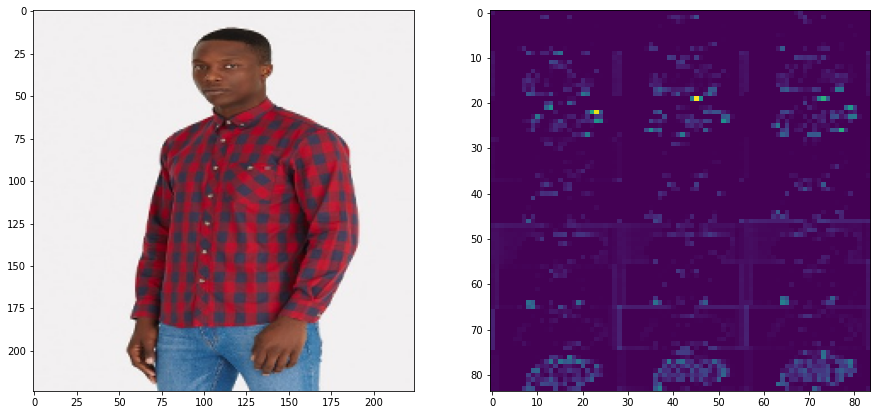

In [ ]:
X_test=read_process_test(224,224)[-1]
conv_base_demo=models.Sequential()
for i in range(11):
    conv_base_demo.add(conv_base.layers[i])
predictions = conv_base_demo.predict(np.array([X_test]))

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,10))
ax1.imshow(cv2.cvtColor(X_test, cv2.COLOR_BGR2RGB))
output=[]
for i in range(3):
    row=[]
    for j in range(3):
        pred=predictions[0,:,:,3*i+j]
        row.append(pred)
    output.append(row)
ax2.imshow(np.reshape(output,(84,84)))
plt.show()

At this point, we can define our densely-connected classifier (note the use of dropout for regularization) layer having 3 classes, and train it on the data and labels that we just recorded:


In [ ]:
model2 = models.Sequential()
model2.add(layers.Dense(256, activation='relu', input_dim=7 * 7 * 512))
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(8, activation='softmax'))
print(model2.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_5 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 6,424,840
Trainable params: 6,424,840
Non-trainable params: 0
_________________________________________________________________
None


Train the network by calling model12.compile() then model.fit() function as we have seen in our earlier exercise, and check its performance. 


**Train more layers in the architecture**
If you train more layers in the proposed architecture you will certainly obtain a better accuracy. For example, freeze the network except the three last weight layers.

In [ ]:
#Create the image generators

tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
callback = EarlyStopping(monitor='val_loss', patience=3)

model2.compile(loss='categorical_crossentropy', 
                optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

history = model2.fit(train_features, Y_train,
                                epochs=20,
                                batch_size=16,
                                validation_data=(val_features,Y_val),
                                callbacks=[callback])


Epoch 1/20
217/217 [==============================] - 2s 6ms/step - loss: 2.9493 - acc: 0.8223 - val_loss: 0.6498 - val_acc: 0.9241
Epoch 2/20
217/217 [==============================] - 1s 6ms/step - loss: 0.7182 - acc: 0.9169 - val_loss: 0.5641 - val_acc: 0.9188
Epoch 3/20
217/217 [==============================] - 1s 6ms/step - loss: 0.4768 - acc: 0.9357 - val_loss: 0.5080 - val_acc: 0.9476
Epoch 4/20
217/217 [==============================] - 1s 6ms/step - loss: 0.3007 - acc: 0.9498 - val_loss: 0.6299 - val_acc: 0.9346
Epoch 5/20
217/217 [==============================] - 1s 6ms/step - loss: 0.2214 - acc: 0.9680 - val_loss: 0.5391 - val_acc: 0.9476
Epoch 6/20
217/217 [==============================] - 1s 6ms/step - loss: 0.1474 - acc: 0.9738 - val_loss: 0.5539 - val_acc: 0.9555


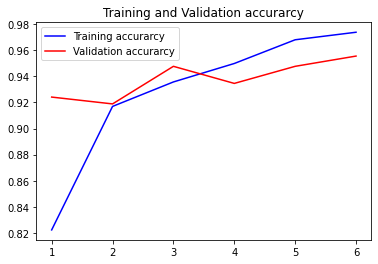

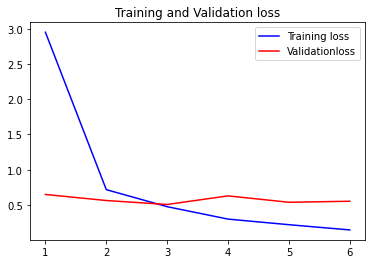

In [ ]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure() #Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validationloss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

If you would like to visualize how images were classified, you can use this part of code:

1/1 [==============================] - 0s 36ms/step


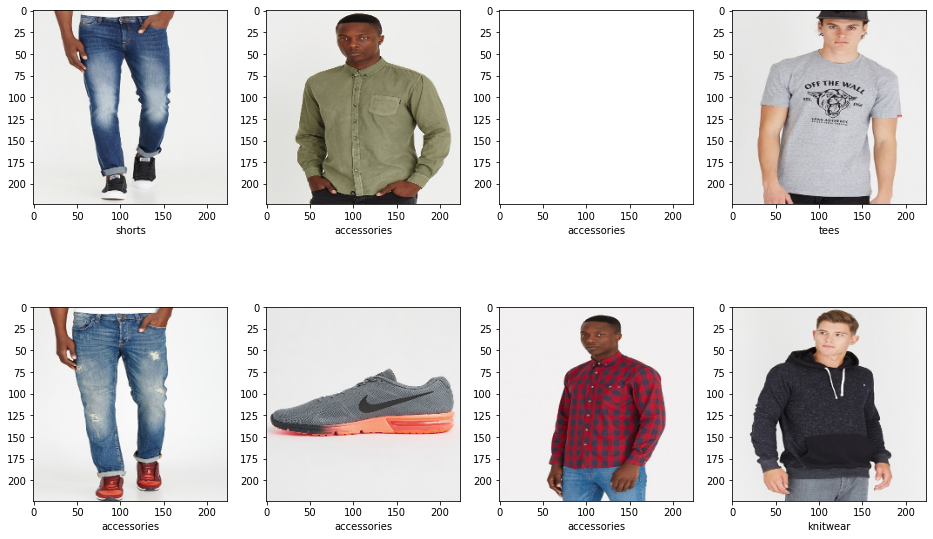

In [ ]:
labels=["accessories","jackets","jeans","knitwear","shirts","shoes","shorts","tees"]
X_test=read_process_test(224,224)
Y_test=model2.predict(np.reshape(conv_base.predict(X_test/255),(len(X_test),7*7*512)))
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16,10))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(labels[np.argmax(Y_test[i])])
    plt.sca(ax)
plt.show()

In [ ]:
'''fnames = validation_generator.filenames
ground_truth = validation_generator.classes
label2index = validation_generator.class_indices
# Getting the mapping from class index to class label
idx2label = dict((v, k) for k, v in label2index.iteritems())
predictions = model12.predict_classes(validation_features)
prob = model12.predict(validation_features)

# to see which images were predicted wrongly
errors = np.where(predictions != ground_truth)[0]print("No of errors = {}/{}".format(len(errors), nVal))
for i in range(len(errors)):    
  pred_class = np.argmax(prob[errors[i]])    
  pred_label = idx2label[pred_class]    
  print('Original label:{}, Prediction :{}, confidence : {:.3f}'.format(fnames[errors[i]].split('/')[0],        pred_label,        prob[errors[i]][pred_class]))    original = load_img('{}/{}'.format(validation_dir, fnames[errors[i]]))    plt.imshow(original)    plt.show()
'''

**2nd technique of feature extraction**: 
consists of extending the conv_base model and running it end-to-end on the inputs. So you can do the following:

In [ ]:
model12 = models.Sequential()
model12.add(conv_base)
model12.add(layers.Flatten())
model12.add(layers.Dense(256, activation='relu'))
model12.add(layers.Dense(8, activation='softmax'))

This is what our model looks like now:


In [ ]:
model12.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_8 (Dense)             (None, 256)               6422784   
                                                                 
 dense_9 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 21,139,528
Trainable params: 6,424,840
Non-trainable params: 14,714,688
_________________________________________________________________


As you can see, the convolutional base of VGG16 has 14,714,688 parameters, which is very large. The classifier we are adding on top has 6 million parameters. Before we compile and train our model, a very important thing to do is to freeze the convolutional base. "Freezing" a layer or set of layers means preventing their weights from getting updated during training. If we don't do this, then the representations that were previously learned by the convolutional base would get modified during training. Since the Dense layers on top are randomly initialized, very large weight updates would be propagated through the network, effectively destroying the representations previously learned. In Keras, freezing a network is done by setting its trainable attribute to False:

In [ ]:
conv_base.trainable = False

With this setup, only the weights from the two Dense layers that we added will be trained. That's a total of four weight tensors: two per layer (the main weight matrix and the bias vector). Now we can start training our model, with optionally a data augmentation configuration that we used in our previous exercise:

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40,
                                   width_shift_range=0.2,height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2,
                                   vertical_flip=True,)
val_datagen = ImageDataGenerator(rescale=1./255) 

train_generator = train_datagen.flow(X_train, Y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, Y_val, batch_size=batch_size)

In [ ]:

NAME = "CNN_FramScratch"
tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))
callback = EarlyStopping(monitor='loss', patience=8)

model12.compile(loss='categorical_crossentropy', 
                optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])

history = model12.fit(train_generator,
                      epochs=50,
                      validation_data=val_generator,
                      callbacks=[tensorboard, callback])

Epoch 1/50
109/109 [==============================] - 42s 374ms/step - loss: 0.8698 - acc: 0.7107 - val_loss: 0.4527 - val_acc: 0.8089
Epoch 2/50
109/109 [==============================] - 42s 386ms/step - loss: 0.4760 - acc: 0.8393 - val_loss: 0.3768 - val_acc: 0.8743
Epoch 3/50
109/109 [==============================] - 41s 377ms/step - loss: 0.4020 - acc: 0.8618 - val_loss: 0.2564 - val_acc: 0.9058
Epoch 4/50
109/109 [==============================] - 41s 375ms/step - loss: 0.3283 - acc: 0.8861 - val_loss: 0.2550 - val_acc: 0.9031
Epoch 5/50
109/109 [==============================] - 41s 373ms/step - loss: 0.3251 - acc: 0.8858 - val_loss: 0.2053 - val_acc: 0.9241
Epoch 6/50
109/109 [==============================] - 40s 370ms/step - loss: 0.2920 - acc: 0.8962 - val_loss: 0.1837 - val_acc: 0.9241
Epoch 7/50
109/109 [==============================] - 39s 359ms/step - loss: 0.2729 - acc: 0.9071 - val_loss: 0.2121 - val_acc: 0.9267
Epoch 8/50
109/109 [==============================] - 4

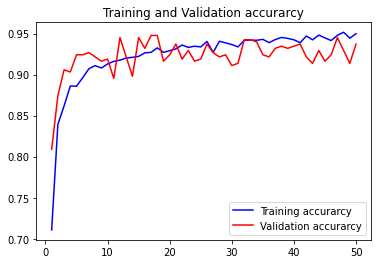

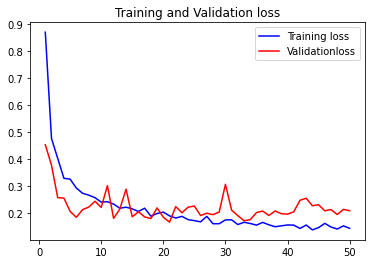

In [ ]:
#lets plot the train and val curve
#get the details form the history object
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()
plt.figure() #Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validationloss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 41ms/step


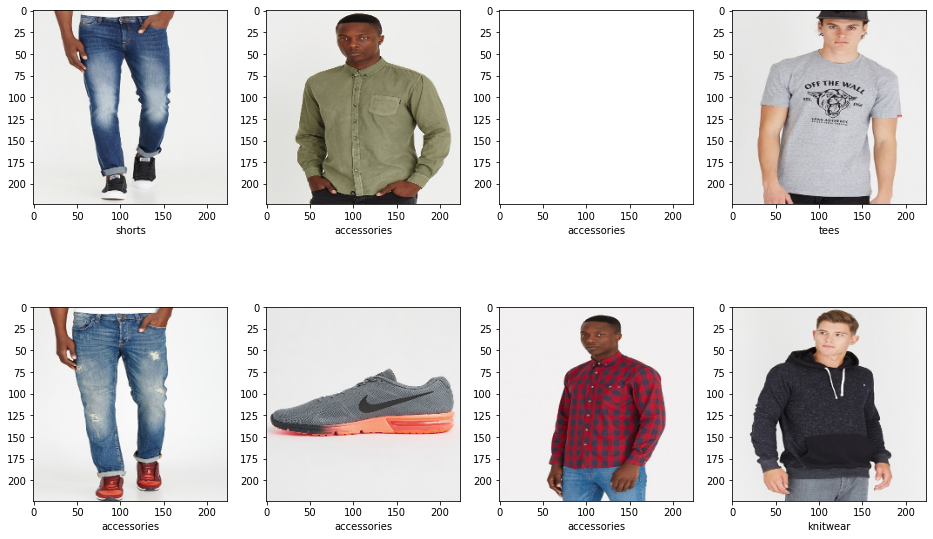

In [ ]:
labels=["accessories","jackets","jeans","knitwear","shirts","shoes","shorts","tees"]
X_test=read_process_test(224,224)
Y_test=model2.predict(np.reshape(conv_base.predict(X_test/255),(len(X_test),7*7*512)))
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16,10))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(cv2.cvtColor(X_test[i], cv2.COLOR_BGR2RGB))
    plt.xlabel(labels[np.argmax(Y_test[i])])
    plt.sca(ax)
plt.show()

Train the network by calling model.fit() function and check its performance as we have seen above.

#1.5. Fine-Tuning a pre-trained model: 
Fine-tuning consists in unfreezing a few of the top layers of a frozen model base used for feature extraction, and jointly training both the newly added part of the model (in our case, the fully-connected classifier) and these top layers. As explained later in the course, the initial layers learn very general features and as we go higher up the network, the layers tend to learn patterns more specific to the task it is being trained on. Thus, for fine-tuning, we want to keep the initial layers intact (or freeze them) and retrain the later layers for our task. Note also that, the more parameters we are training, the more we are at risk of overfitting. 

First, we will load a VGG model without the top layer (which consists of fully connected layers). Then, we will fine-tune the last 4 layers:

In [ ]:
conv_base = VGG16(weights='imagenet',                  
                  include_top=False,                  
                  input_shape=(224, 224, 3))

# Freeze the layers except the last 4 layers
for layer in conv_base.layers[:-4]:    
  layer.trainable = False
  # Check the trainable status of the individual layers
  for layer in conv_base.layers:    
    print(layer, layer.trainable)

NameError: ignored

Now that we have set the trainable parameters of our base network, we would like to add a classifier on top of the convolutional base, and set up the data for training exactly like the previous exercise. Check out the performance. To see the effect of fine-tuning and data augmentation, you can perform experiments with and without data augmentation, and with freezing all layers and learning a classifier on top of it, similar to transfer learning, and training the last 3 convolutional layers.

#1.6. Find similar images for an input image 

Here, we can use any of the techniques previously presented. If we take the 1st feature extraction technique (Ex. 1.4). The network accepts an input image with 224x224x3 dimension. The part from the first convolutional layer to the last pooling player (7x7x512) is the feature extraction part. Then, the remaining layers is the classification part. So, if we want to get the feature of an image, we only need the result of the feature extraction part. 
After loading each image from reference dataset (train part), we feed the it to the the VGG16 network, and extract its feature. Then, the final feature matrix (7x7x512 in dimension) is flattened to make a 1D-vector

One of the most simple step to build search service is by using k-nearest neighbor method. We will compare the vector representation of the query image to all the image in our database, and then giving the k most similar images. This method can be done since each vector has the same length, so we can plot them and calculate their pairwise distance.
The other thing to consider is how we want to measure the “similarity” between images, i.e. how to calculate the distance between the vector from the query with each vector in database. Here, we decide to use cosine distance. We choose this rather than the more simple metrics, euclidean distance, since we want to measure the correlation between each element in the vectors, rather than the element itself. Cosine distance does that by calculating the angle between each vector pairs instead of calculating their L2 distance.

In [ ]:
X_train,Y_train=read_process("train",224,224)
X_val,Y_val=read_process("valid",224,224)

nTrain = len(X_train)
nVal = len(X_val)

train_features,val_features = conv_base.predict(X_train),conv_base.predict(X_val)
train_features,val_features = np.reshape(train_features, (nTrain, 7 * 7 * 512)),np.reshape(val_features, (nVal, 7 * 7 * 512))

print(train_features.shape,Y_train.shape)
print(val_features.shape,Y_val.shape)


12/12 [==============================] - 2s 159ms/step
(3467, 25088) (3467, 8)
(382, 25088) (382, 8)


In [ ]:
flatten_features = [feature.flatten() for feature in train_features]
print(np.shape(flatten_features))

(3467, 25088)


In [ ]:
import random
from scipy import spatial

def find_k_kneighbors(flatten_features, k):
  origin_index = random.randint(0, len(flatten_features)-1)
  origin_features = flatten_features[origin_index]
  similarities = {}
  for i,feature in enumerate(flatten_features):
    similarity = spatial.distance.cosine(origin_features, feature)
    similarities[i] = similarity
  sorted_similarities = {k: v for k, v in sorted(similarities.items(), key=lambda item: item[1])}
  return origin_index, dict(itertools.islice(sorted_similarities.items(), k))



In [ ]:
origin, example = find_k_kneighbors(flatten_features, 7)
print(example)
print(origin)

{581: 0, 3304: 0.16716450452804565, 1555: 0.1787765622138977, 2789: 0.19443410634994507, 3150: 0.20503437519073486, 77: 0.20662003755569458, 2772: 0.20952868461608887}
581


IndexError: ignored

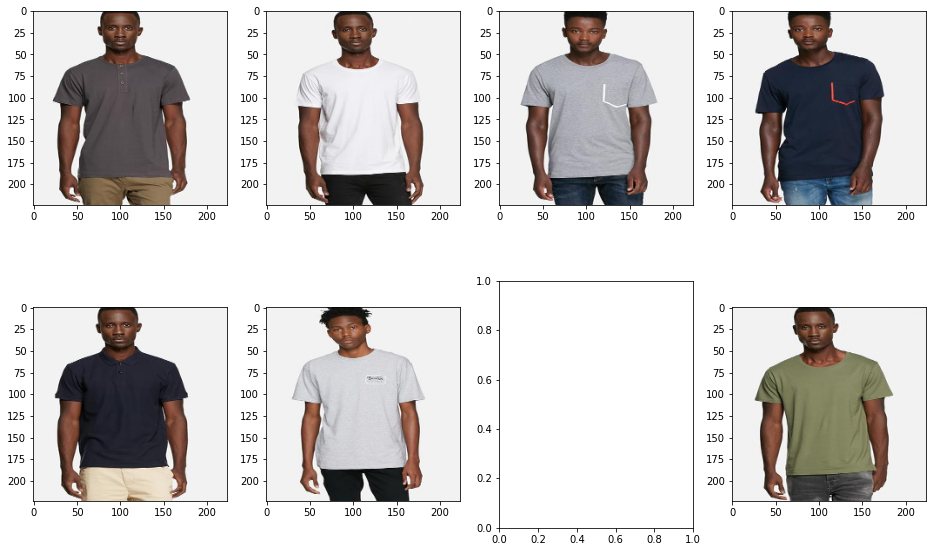

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16,10))
for i, ax in enumerate(axs.flatten()):
    plt.imshow(cv2.cvtColor(X_train[list(example.keys())[i]], cv2.COLOR_BGR2RGB))
    plt.sca(ax)
plt.show()

#1.7. Visualizing Image Clusters 

To do this, we need to reduce the dimensions of the feature vectors because it’s not possible to plot a 1024-dimension vector (the feature-length) in two dimensions. So it is a good idea to reduce the dimensionality using Principal Component Analysis (PCA)


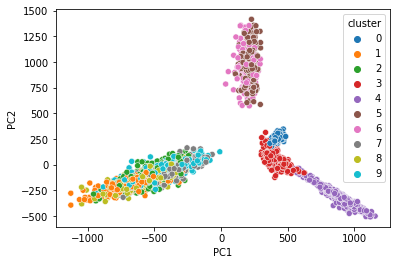

In [ ]:
from sklearn.decomposition import PCA 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans


pca = PCA(2) 
pca_data = pd.DataFrame(pca.fit_transform(flatten_features),columns=['PC1','PC2'])
kmeans =KMeans(n_clusters=8).fit(flatten_features)
pca_data['cluster'] = pd.Categorical(kmeans.labels_)
sns.scatterplot(x="PC1",y="PC2",hue="cluster",data=pca_data)